In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import json

import sys
import time
from IPython.display import display, clear_output
import torch
import warnings
import gym

from cryoenv.mqtt import SoftActorCritic, ReturnTracker, ReplayBuffer, check, subscribe, publish, connect_mqtt
from cryoenv.envs import CryoEnvSigWrapper

from mqtt_protocol import *
from on_message_notebook import receive_as_daq

In [2]:
np.random.seed(rseed)

In [3]:
warnings.simplefilter('ignore')

In [4]:
client_id = 'daq-primary'

In [5]:
env = gym.make('cryoenv:cryoenv-sig-v0',
                   omega=omega,
                   sample_pars=False,
                   pars={'store_raw': False,
                         'max_buffer_len': buffer_size,
                         'tpa_queue': tpa_queue,
                         'pileup_prob': pileup_prob,
                         'xi': np.array([xi]),
                         'tau': np.array([tau]),},
               render_mode='human',
                   )

In [6]:
userdata = {'channel': channel,
            'msg_received': 0, 
            'action': env.action_space.sample(),
            'set_pars_msg': set_pars_msg,
            'subscribe_acknowledge_msg': subscribe_acknowledge_msg,
            'subscribe_channel_msg': subscribe_channel_msg,
            'trigger_msg': trigger_msg,
            'acknowledge_msg': acknowledge_msg,
            'adc_range': adc_range,
            'dac_range': dac_range,
            'Ib_range': Ib_range,
           }

client = connect_mqtt(broker, port, client_id, username, password, userdata=userdata)

In [7]:
subscribe(client, subscribe_channel_msg['topic'])
subscribe(client, set_pars_msg['topic'])

In [8]:
client.on_message = receive_as_daq

Action:  [-0.44592401 -0.91281021]
Reward:  -0.0008508257740210684
ChannelID 1
TPA 1
LBaseline 0
PulseHeight 0.18963906096541583
RMS 6.911435926904019e-05
DAC 0.5540759861469269
BiasCurrent 0.08718979358673096
Samples (16384,)
steps: 150, msg received: 145


KeyboardInterrupt: 

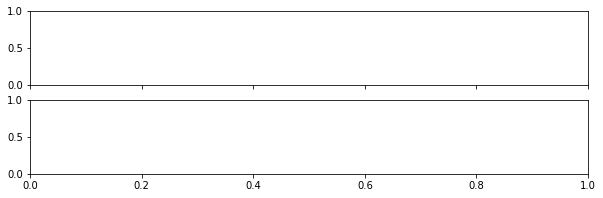

In [9]:
terminated, truncated = False, False
    
state, info = env.reset()
steps = 0

while not terminated and not truncated:
    
    time.sleep(.1)
    clear_output(wait=True)
    
    print('Action: ', userdata['action'])
    new_state, reward, terminated, truncated, info = env.step(userdata['action'].flatten())
    print('Reward: ', reward)
        
    payload = {
        'ChannelID': userdata['channel'], 
        'TPA': int(env.detector.tpa_queue[env.detector.tpa_idx if env.detector.tpa_idx != 0 else len(env.detector.tpa_queue) - 1][0]), 
        'LBaseline': 0, 
        'PulseHeight': (new_state[0] + 1) / 2 * adc_range[1], 
        'RMS': (new_state[1] + 1) / 2 * adc_range[1], 
        'DAC': dac_range[0] + (new_state[3] + 1) / 2 * (dac_range[1] - dac_range[0]), 
        'BiasCurrent': Ib_range[0] + (new_state[2] + 1) / 2 * (Ib_range[1] - Ib_range[0]), 
        'Samples': (env.detector.get_record().flatten() * 10./65536.).tolist(),
    }
    
    for k,v in zip(payload.keys(), payload.values()):
        if k == 'Samples':
            print(k,np.array(v).shape)
        else:
            print(k,v)

    result = client.publish(trigger_msg['topic'], json.dumps(payload))
    check(result)
        
    steps += 1
    state = new_state

    print('steps: {}, msg received: {}'.format(steps, userdata['msg_received']))

    env.render()
    sys.stdout.flush()
    
    for i in range(5):
        client.loop(.1)  # here the new action is set
        
    if userdata['msg_received'] > 200:
        break

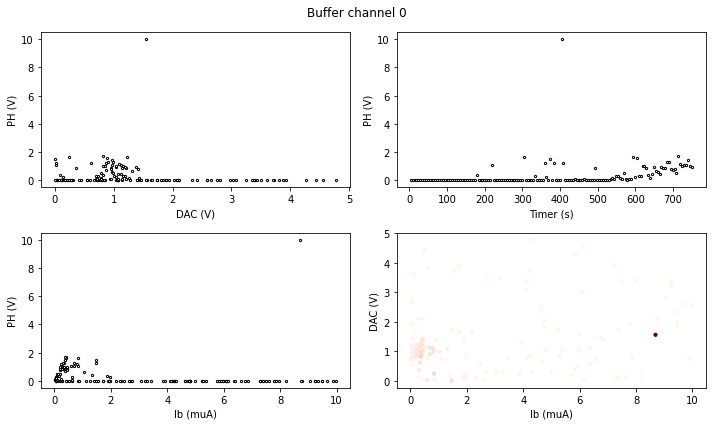

In [10]:
env.detector.plot_buffer()